In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

In [2]:
# two input values and only one output value

# dimensions of input, hidden and output layers
N0 = 2
N1 = 30
N2 = 1

In [3]:
# activation function

# smooth function return values between 0 and 1
def sigmoid(x):
    s = 1 / (1 + np.exp(-x)) # nonlinear function for forward propagation
    ds = np.exp(-x) * s**2   # derivative for brackward propagation
    
    return s, ds


# nonsmooth function return values 0 or 1
def theta(x):
    
    if x < 0:
        return 1
    else:
        return 0

In [4]:
# output function

# dictionary containing activation functions
activation_dict = {"theta": theta, "sigmoid": sigmoid}

# operations performed at each layer
def layer(act, v, w, b):
    
    z = np.dot(v, w) + b           # linear superposition of all neurons from the previous layer
    return activation_dict[act](z) # application of nonlinear function and calculation of the derivative

In [5]:
# making a network with n hidden layers

# number of hidden layers, minimum number of hidden layers to be used: 1
layer_count = 4

# size of all the layers in a list, this includes input and output layers
layers = [N0]

for l in range(layer_count):
    layers.append(N1)
    
layers.append(N2)

print("Layer structure of the network: ", layers)

# weights and biases used for transitions between the layers including the input and output layer
weights = [np.random.uniform(low = -10, high = +10, size = (layers[k], layers[k+1])) for k in range(len(layers)-1)]
bias = [np.random.uniform(low = -1, high = +1, size = (layers[k+1])) for k in range(len(layers)-1)]

# propagation through a network with at least one hidden layer
def network_multi(y_in, activation, n):
    
    # storage arrays
    layer_vals = [np.empty((M**2, layers[j])) for j in range(len(layers))]       # layer values (backward propagation)
    layer_vals_df = [np.empty((M**2, layers[j])) for j in range(1, len(layers))] # layer derivatives (backward propagation)    
    
    y_vals = y_in
    layer_vals[0] = y_vals
    
    for i in range(n+1):
        y_vals, y_df = layer(activation, y_vals, weights[i], bias[i])
        layer_vals[i+1] = y_vals
        layer_vals_df[i] = y_df
    
    return layer_vals, layer_vals_df

Layer structure of the network:  [2, 30, 30, 30, 30, 1]


In [6]:
# visualize

M = 100

y1, y2 = np.meshgrid(np.linspace(-0.5, 0.5, M), np.linspace(-0.5, 0.5, M))

y1_flat = y1.flatten()
y2_flat = y2.flatten()

y_in = np.empty((len(y1_flat), 2))
y_in[:,0] = y1_flat
y_in[:,1] = y2_flat

# print(np.shape(y_in))

plotmatrix = network_multi(y_in, "sigmoid", layer_count)[0][-1]

plotmatrix = np.reshape(plotmatrix[:, 0], (M, M))

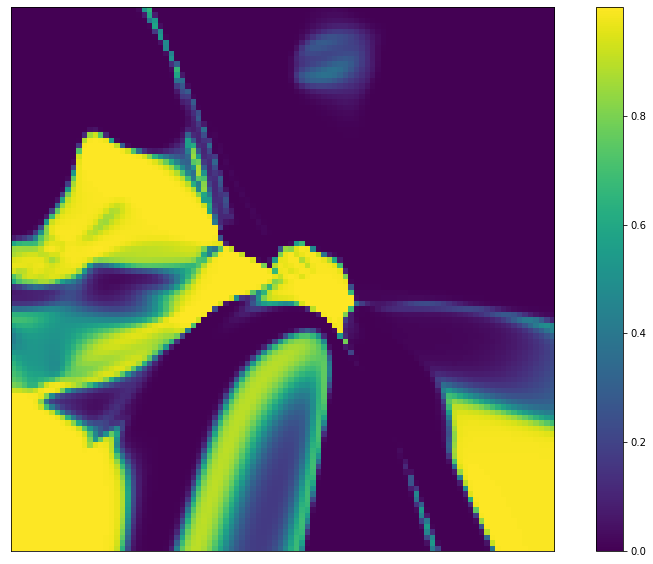

In [7]:
# plot

plt.figure(figsize = (15, 10), facecolor = "white")

plt.imshow(plotmatrix, origin = "lower")
plt.colorbar()

#, extent=(-0.5,0.5,-0.5,0.5)

plt.xticks([], [])
plt.yticks([], [])

# plt.hlines(50, 0, 99)
# plt.vlines(50, 0, 99)

# plt.xlim(0, 99)
# plt.ylim(0, 99)

plt.show()

In [8]:
# this is the main backpropagation

def backward_step(delta, w, df):
    
    return np.dot(delta, np.transpose(w)) * df

In [9]:
# backpropagation algorithm

batchsize = 200

def backpropagation(y_nn, y_nn_df, y_target):
    
    dw = [np.empty((layers[j], layers[j+1])) for j in range(len(layers)-1)]
    db = [np.empty((layers[j+1])) for j in range(len(layers)-1)]
    
    delta_y = (y_nn[-1] - y_target) * y_nn_df[-1]
    
    
    dw[-1] = np.dot(np.transpose(y_nn[-2]), delta_y) / batchsize
    db[-1] = delta_y.sum(0) / batchsize
    
    for i in range(len(layers) - 2):
        
        delta_y = backward_step(delta_y, weights[-1-i], y_nn_df[-2-i])
        dw[-2-i] = np.dot(np.transpose(y_nn[-3-i]), delta_y)
        db[-2-i] = delta_y.sum(0) / batchsize
        
    return dw, db
    

In [10]:
# gradient descend

def gradient_step(eta, dweights, dbias):
    
    for i in range(len(layers) - 1):
        weights[i] -= eta * dweights[i]
        bias[i] -= eta * dbias[i]

In [11]:
# this is the part where the network is beign trained

def train_net(y, y_target, activation, n):
    
    y_out, y_out_df = network_multi(y, activation, n)
    
    y_target = np.reshape(y_target, (M**2, 1))
    
    dw, db = backpropagation(y_out, y_out_df, y_target)
    
    gradient_step(0.001, dw, db)
    
    cost = ((y_target - y_out[-1])**2).sum() / batchsize
        
    return cost, y_out[-1]

In [12]:
# iterative training

target = np.zeros((M, M))
quad_1 = np.ones((M//2, M//2))
target[:M//2, M//2:] = quad_1
target[M//2:, :M//2] = quad_1

costs = np.empty(batchsize)
images = [None] * batchsize

for i in range(batchsize):
    
    costs[i], images[i] = train_net(y_in, target, "sigmoid", layer_count)

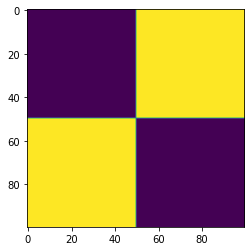

In [13]:
plt.imshow(target)
plt.show()

<IPython.core.display.Javascript object>


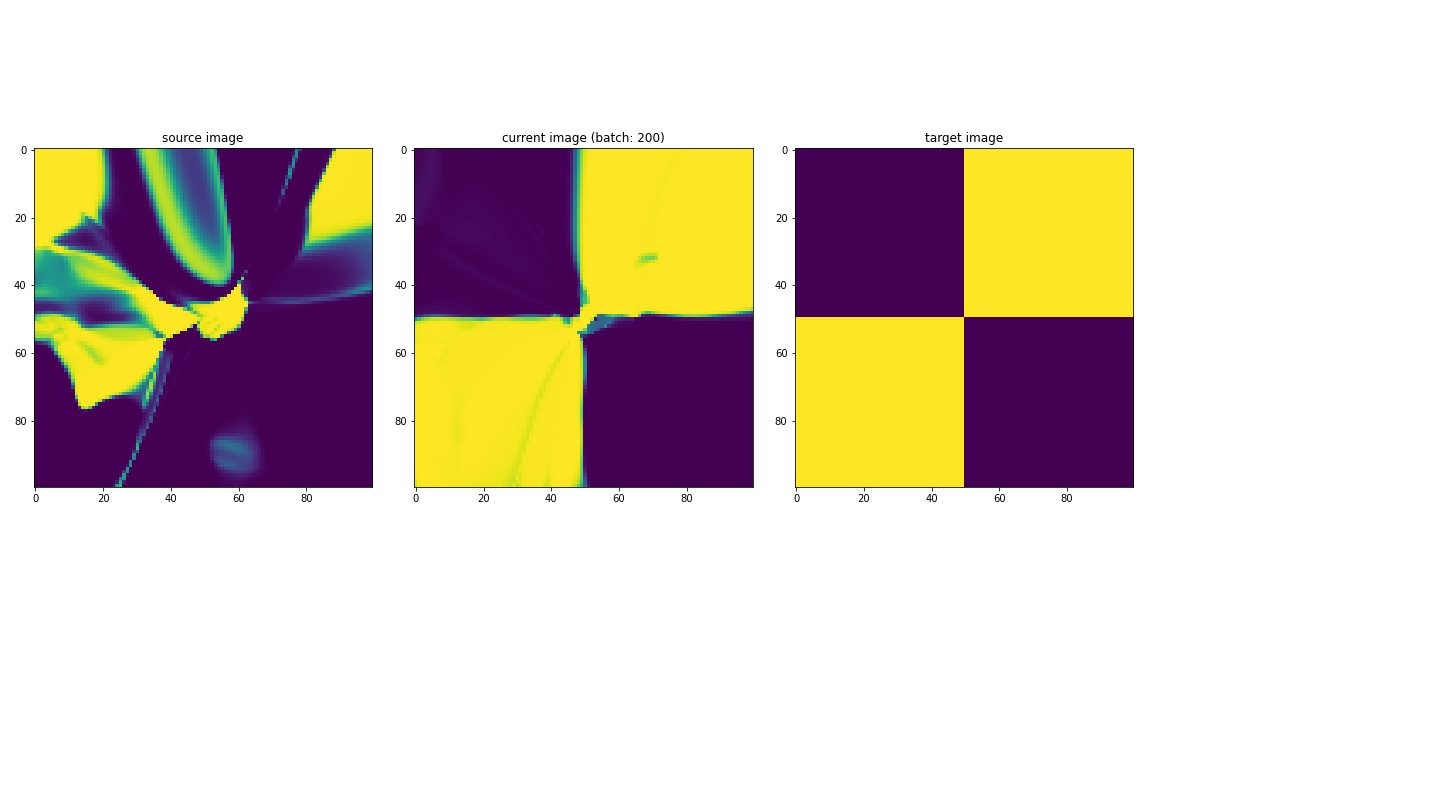

In [20]:
# make an animation out of this

%matplotlib inline
%reload_ext autoreload
%autoreload 2
%matplotlib notebook

#plt.rcParams['figure.dpi'] = 

fig = plt.figure(figsize = (16, 9), facecolor = "white")
fig.canvas.toolbar_visible = False
fig.show()

ax_start = fig.add_subplot(131)
ax_current = fig.add_subplot(132)
ax_target = fig.add_subplot(133)

plt.tight_layout()

#plt.ion()
ax_start.imshow(np.reshape(images[0][:, 0], (M, M)))
ax_start.set_title('source image')

ax_target.imshow(target)
ax_target.set_title('target image')
#plt.ioff()

for i in range(batchsize):
    
    ax_current.cla()
    
    ax_current.set_title(f'current image (batch: {i+1})')
    ax_current.imshow(np.reshape(images[i][:, 0], (M, M)))
    fig.canvas.draw()
    #sleep(0.001)
    
    # plt.savefig(f"out\\nn_image_{i+1}", dpi = 150, facecolor = "white")
    
plt.close(fig)

<IPython.core.display.Javascript object>


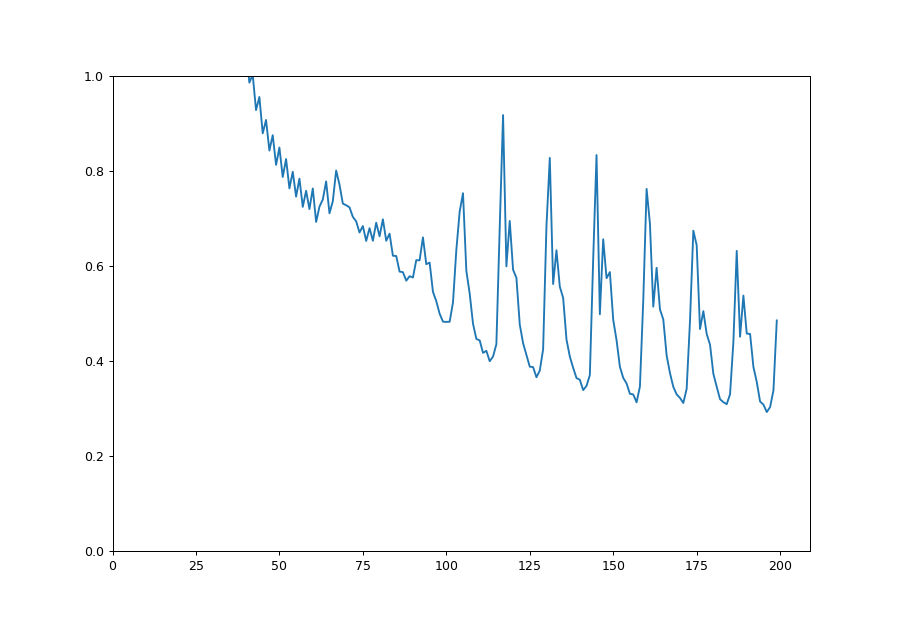

In [15]:
# plot the costs

plt.figure(figsize = (10, 7), facecolor = "white")

plt.plot(costs)

plt.xlim(0, None)
plt.ylim(0, 1)

plt.show()

In [16]:
%matplotlib -l

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']
